## Install Libraries

In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install unsloth
# Get latest Unsloth
!pip install --upgrade --no-deps "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# %%

In [2]:
!pip install -q -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.6 MB/s eta 0:00:0000:01


In [2]:
!pip install nlpaug transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 10.3 MB/s eta 0:00:0000:01


## Product Review Category Balancing via BERT-based Augmentation

- Loaded and cleaned a category-labeled product review dataset by retaining only relevant columns and stripping unwanted formatting.
- Used `nlpaug` with BERT-based contextual augmentation to synthetically balance underrepresented categories.
- Saved the final balanced dataset as `Final Product Category Balanced Dataset.csv` for downstream classification tasks.


In [ ]:
import pandas as pd
# Load the dataset from a CSV file
df = pd.read_csv('/kaggle/input/final-mapped-dataset-category-labeled/Final Mapped Product Review Of AliExpress Product Category Processed.csv')


# Remove all columns except 'reviewContent' and 'categoryLabel'
df = df[['reviewContent', 'categoryLabel']]

# Display initial data and label counts
print("Updated Dataset:")
print(df.head())  # Display the first few rows to verify
print("\nLabel Counts:")
print(df['categoryLabel'].value_counts())

Updated Dataset:
                                       reviewContent categoryLabel
0                  Small, it won't work for the car.    automotive
1  Very satisfied with the product, it is really ...    automotive
2             Very satisfied with this little vacuum    automotive
3               Just a bomb! Works like a hurricane!   electronics
4          This thing is a monster. Worth every coin   electronics

Label Counts:
categoryLabel
electronics    5606
automotive     5062
fashion        1391
home            642
health          215
Name: count, dtype: int64


In [ ]:
import nlpaug.augmenter.word as naw
import pandas as pd
from tqdm import tqdm

# Initialize the word augmentor using BERT
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

def augment_category_reviews(df, category, target_size):
    """
    Augments reviews of a given category to meet the target size.
    """
    current_size = df[df['categoryLabel'] == category].shape[0]
    
    if current_size >= target_size:
        print(f"Category '{category}' already has {current_size} reviews. No augmentation needed.")
        return df[df['categoryLabel'] == category]
    
    num_reviews_to_generate = target_size - current_size
    category_reviews = df[df['categoryLabel'] == category]['reviewContent'].tolist()
    
    augmented_reviews = []
    print(f"Generating {num_reviews_to_generate} augmented reviews for category '{category}'")
    with tqdm(total=num_reviews_to_generate, desc=f"Augmenting {category}") as pbar:
        while len(augmented_reviews) < num_reviews_to_generate:
            for review in category_reviews:
                augmented_review = aug.augment(review)
                augmented_reviews.append(augmented_review)
                pbar.update(1)
                if len(augmented_reviews) >= num_reviews_to_generate:
                    break
    
    augmented_reviews = augmented_reviews[:num_reviews_to_generate]
    
    augmented_data = pd.DataFrame({
        'reviewContent': category_reviews + augmented_reviews,
        'categoryLabel': [category] * (current_size + num_reviews_to_generate)
    })
    
    return augmented_data

# Main augmentation driver
def balance_dataset_by_augmentation(df):
    target_size = df['categoryLabel'].value_counts().max()
    augmented_dfs = []

    for category in df['categoryLabel'].unique():
        print(f"\nAugmenting category: {category}")
        augmented_df = augment_category_reviews(df, category, target_size)
        augmented_dfs.append(augmented_df)

    df_balanced = pd.concat(augmented_dfs, ignore_index=True)

    print("\n✅ Updated Label Counts After Augmentation:")
    print(df_balanced['categoryLabel'].value_counts())
    
    return df_balanced

# Example usage:
df_balanced = balance_dataset_by_augmentation(df)

df_balanced.to_csv('final Product Category Balanced Dataset.csv')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Augmenting category: automotive
Generating 544 augmented reviews for category 'automotive'


Augmenting automotive: 100%|██████████| 544/544 [03:45<00:00,  2.41it/s]



Augmenting category: electronics
Category 'electronics' already has 5606 reviews. No augmentation needed.

Augmenting category: home
Generating 4964 augmented reviews for category 'home'


Augmenting home: 100%|██████████| 4964/4964 [57:57<00:00,  1.43it/s]  



Augmenting category: health
Generating 5391 augmented reviews for category 'health'


Augmenting health: 100%|██████████| 5391/5391 [1:01:38<00:00,  1.46it/s]



Augmenting category: fashion
Generating 4215 augmented reviews for category 'fashion'


Augmenting fashion: 100%|██████████| 4215/4215 [50:37<00:00,  1.39it/s]  


✅ Updated Label Counts After Augmentation:
categoryLabel
automotive     5606
electronics    5606
home           5606
health         5606
fashion        5606
Name: count, dtype: int64


In [6]:
import pandas as pd
from textblob import TextBlob

def clean_reviews(df):
    """
    Clean the 'reviewContent' column by removing square brackets and single quotes
    at the beginning and end of the review content, and correcting spelling errors.
    
    Parameters:
    - df: The DataFrame containing the 'reviewContent' column.
    
    Returns:
    - DataFrame with cleaned and spell-corrected 'reviewContent'.
    """
    # Clean reviews: If the review starts with [' and ends with '], remove them
    df['reviewContent'] = df['reviewContent'].apply(lambda x: x[2:-2] if x.startswith("['") and x.endswith("']") else x)
    
    # Correct spelling in reviews
    #df['reviewContent'] = df['reviewContent'].apply(lambda x: str(TextBlob(x).correct()))
    
    return df

# Example usage:
# Load the dataset
df = pd.read_csv('/kaggle/working/final Product Category Balanced Dataset.csv')

# Clean the 'reviewContent' column
df = clean_reviews(df)

# Remove all columns except 'reviewContent' and 'categoryLabel'
df = df[['reviewContent', 'categoryLabel']]

# Display initial data and label counts
print("Updated Dataset:")
print(df.head())  # Display the first few rows to verify
print("\nLabel Counts:")
print(df['categoryLabel'].value_counts())


Updated Dataset:
                                       reviewContent categoryLabel
0                  Small, it won't work for the car.    automotive
1  Very satisfied with the product, it is really ...    automotive
2             Very satisfied with this little vacuum    automotive
3  Very good. Car indoor cleaning and keyboard, w...    automotive
4                         Very satisfied. It's good.    automotive

Label Counts:
categoryLabel
automotive     5606
electronics    5606
home           5606
health         5606
fashion        5606
Name: count, dtype: int64


In [7]:
df.to_csv('Final Product Category Balanced Dataset.csv')

## Load and Shuffle Final Balanced Product Category Dataset

- Loaded the cleaned and balanced dataset and retained only the `reviewContent` and `categoryLabel` columns.
- Shuffled the entire dataset to randomize sample order for unbiased training and evaluation.


In [3]:
import pandas as pd
df = pd.read_csv('/kaggle/input/final-balanced-product-category-dataset/Final Product Category Balanced Dataset.csv')
# Remove all columns except 'reviewContent' and 'categoryLabel'
df = df[['reviewContent', 'categoryLabel']]

In [4]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head(10)


,reviewContent,categoryLabel
0,"Very good the product, looks good quality, my ...",automotive
1,nice little product. maybe it fits you thinner...,health
2,"It is very good, who knows the brand knows tha...",fashion
3,very firmly satisfied. in just 9 days and it a...,fashion
4,very good product with good seams fits well ev...,home
5,"Waiting to test them, they look quite closely ...",automotive
6,the intended seller is probably not decent! or...,health
7,The seller by mistake sent a different wedding...,electronics
8,Super memory very complete and very fast,electronics
9,"Received, not yet proven.",electronics


# **Train Test Split**
* **Data Preparation:** The code splits the dataset into training, testing, and evaluation sets for each category (automotive, fashion, home, electronics, and health), ensuring balanced sampling with 2500 examples for training and testing in each category.

* **Prompt Generation:** A prompt generation function is defined to create text-based prompts from the reviews. The prompts are tailored for multi-class classification by specifying a review's category, which is then passed to the model.

* **Dataset Conversion:** The training and evaluation data are converted into Hugging Face datasets, and the labels are prepared for evaluation. The testing data prompts are also formatted for model input.

* **Evaluation Metrics:** The evaluation function computes key performance metrics such as accuracy, classification report, and confusion matrix. It provides detailed evaluation by category, measuring both overall and label-specific performance.

* **Testing with Model:** The generated test prompts are intended for classification, where the model predicts the category based on the review content, and the evaluation function is used to compare predicted labels with true labels.

In [5]:
from sklearn.model_selection import train_test_split

# Define candidate labels
#categoryLabel = [
#'automotive', 'fashion', 'Home', 'Electronics', 'health']

# Train-test split for each category
X_train = list()
X_test = list()

for category in ["automotive", "fashion", "home","electronics","health"]:
    train, test = train_test_split(df[df.categoryLabel==category], 
                                   train_size=3500, test_size=2100, random_state=42)
    X_train.append(train)
    X_test.append(test)

# Concatenate the training and testing sets for each sentiment
X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

# Create an evaluation set from the remaining data points
eval_idx = [idx for idx in df.index if idx not in list(train.index) + list(test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('categoryLabel', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

<ipython-input-5-51fe9f27b359>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))


In [6]:
# Modify the prompt function for multi-class classification
def generate_prompt(data_point):
    return f"""
            Determine the class if the review enclosed in square brackets is automotive or fashion or home or electronics or health category class based on its content.
            Return the answer as either "automotive" or "fashion" or "home"or "electronics" or "health".

            [{data_point["reviewContent"]}] = {data_point["categoryLabel"]}
            """.strip()

In [7]:
from datasets import Dataset
def generate_test_prompt(data_point):
    return f"""
            Determine the class if the review enclosed in square brackets is automotive or fashion or home or electronics or health category class based on its content.
            Return the answer as either "automotive" or "fashion" or "home" or "electronics" or "health".

            [{data_point["reviewContent"]}] =
            """.strip()

# Create DataFrames for training and evaluation data with generated prompts
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1),
                       columns=["reviewContent"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1),
                      columns=["reviewContent"])
     
# The labels for the true values (test set) would be used for evaluation
y_true = X_test.categoryLabel

# Create a DataFrame for testing data with generated prompts
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["reviewContent"])

# Convert to Hugging Face datasets
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)


In [8]:
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
import numpy as np
def evaluate(y_true, y_pred):
    labels = ['automotive', 'fashion', 'home', 'electronics', 'health']
    mapping = {'automotive':0, 'fashion':1, 'home':2, 'electronics':3, 'health':4}
    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1])
    print('\nConfusion Matrix:')
    print(conf_matrix)

# Model Import, PEFT Setup, and Post-Evaluation

- **Model Import**: The "unsloth/mistral-7b-bnb-4bit" model is imported with 4-bit quantization to reduce memory usage, and it supports RoPE scaling for efficient processing.

- **PEFT Fine-Tuning Setup**: The model is prepared for Parameter Efficient Fine-Tuning (PEFT) by identifying and setting up linear layers eligible for fine-tuning with the `find_all_linear_names` function.

- **Prediction Function**: The `predict` function generates category predictions for each review in the test set, decoding model outputs and mapping them to predefined categories (automotive, fashion, home, electronics, health).

- **Post Evaluation**: After generating predictions, the model's performance is evaluated using the `evaluate` function, comparing predicted labels with true labels to assess accuracy and classification results before any fine-tuning.


In [12]:
import unsloth
from unsloth import FastLanguageModel
import torch
# Load the model
max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
dtype = None  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True  # Use 4bit quantization to reduce memory usage
#AbuSalehMd/ProductCategoryClassificationFinal_Mistral_7B_FineTuned
#AbuSalehMd/ProductCategoryClassification_Mistral_7B_FineTuned
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="AbuSalehMd/ProductCategoryClassificationFinal_Mistral_7B_FineTuned", 
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

==((====))==  Unsloth 2025.3.19: Fast Mistral patching. Transformers: 4.51.2.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

In [10]:
# Prepare the model for PEFT fine-tuning
import bitsandbytes as bnb
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    return list(lora_module_names)

modules = find_all_linear_names(model)
print(modules)


['up_proj', 'k_proj', 'gate_proj', 'down_proj', 'q_proj', 'o_proj', 'v_proj']


In [13]:
from tqdm import tqdm

def predict(X_test, model, tokenizer):
    y_pred = []
    answers = [] 
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["reviewContent"]
        input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
        outputs= model.generate(**input_ids,pad_token_id=tokenizer.eos_token_id, max_new_tokens=3,temperature=0.0)
        result = tokenizer.decode(outputs[0])
        answer = result.split("=")[-1].lower()
        #answers.append(answer)
        if "automotive" in answer:
            y_pred.append("automotive")
        elif "fashion" in answer:
            y_pred.append("fashion")
        elif "home" in answer:
            y_pred.append("home")
        elif "electronics" in answer:
            y_pred.append("electronics")
        elif "health" in answer:
            y_pred.append("health")
        else:
            y_pred.append("none")
    # Print all answers after the loop finishes
    #print("Generated Answers:")
    #print(answers)
    return y_pred

In [19]:
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 10500/10500 [1:25:06<00:00,  2.06it/s]

Accuracy: 0.276
Accuracy for label 0: 0.924
Accuracy for label 1: 0.195
Accuracy for label 2: 0.140
Accuracy for label 3: 0.022
Accuracy for label 4: 0.096

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.92      0.38      2100
           1       0.28      0.19      0.23      2100
           2       0.83      0.14      0.24      2100
           3       0.22      0.02      0.04      2100
           4       0.86      0.10      0.17      2100

    accuracy                           0.28     10500
   macro avg       0.49      0.28      0.21     10500
weighted avg       0.49      0.28      0.21     10500


Confusion Matrix:
[[1941  145]
 [1553  409]]


# PEFT Fine-Tuning and Training Loss Visualization

- **PEFT Fine-Tuning**: The model is fine-tuned using Parameter Efficient Fine-Tuning (PEFT) with optimizations like `lora_alpha`, dropout settings, and gradient checkpointing to improve training efficiency and reduce memory usage.

- **Training Setup**: The `SFTTrainer` from the `trl` library is configured with specific training parameters such as batch size, learning rate, and optimizer to fine-tune the model for sentiment analysis.

- **Loss Visualization**: Training losses are extracted from the log history and plotted using `matplotlib`, displaying the loss curve to monitor the model's performance during training.


In [11]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = modules,
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [16]:
from trl import SFTTrainer
from transformers import TrainingArguments
# Training setup
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_data,
    eval_dataset=eval_data,
    dataset_text_field="reviewContent",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,  # Can make training 5x faster for short sequences
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        num_train_epochs=2,
        learning_rate=2e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=50,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",
    ),
)


Unsloth: Tokenizing ["reviewContent"] (num_proc=2):   0%|          | 0/17500 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["reviewContent"] (num_proc=2):   0%|          | 0/250 [00:00<?, ? examples/s]

In [17]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla P100-PCIE-16GB. Max memory = 15.888 GB.
6.883 GB of memory reserved.


In [18]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 17,500 | Num Epochs = 2 | Total steps = 4,374
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 167,772,160/7,000,000,000 (2.40% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
50,0.727500
100,0.701200
150,0.723900
200,0.699300
250,0.653000
300,0.683800
350,0.646100
400,0.660000
450,0.664800
500,0.648800


In [19]:
trainer_stats

TrainOutput(global_step=4374, training_loss=0.5303792794327459, metrics={'train_runtime': 40192.8413, 'train_samples_per_second': 0.871, 'train_steps_per_second': 0.109, 'total_flos': 1.8287261927930266e+17, 'train_loss': 0.5303792794327459})

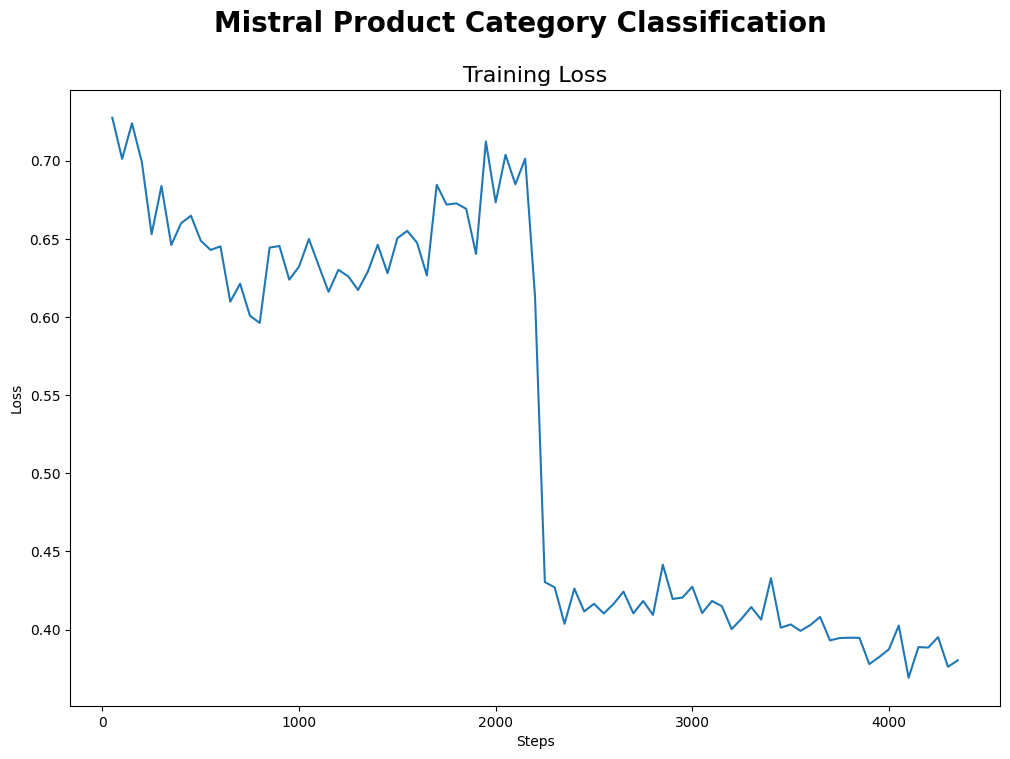

In [ ]:
import matplotlib.pyplot as plt

# Extract the training losses from the log history
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
# Extract the training steps from the log history
steps = [log["step"] for log in trainer.state.log_history if "loss" in log]

# Create the figure with larger size
plt.figure(figsize=(12, 8))  # Adjust the width and height (in inches)

# Plotting the loss curve
plt.plot(steps, losses)

# Adding a heading for the figure
plt.suptitle("Mistral Product Category Classification", fontsize=20, fontweight='bold')

# Adding the title, axis labels, and displaying the plot
plt.title("Training Loss", fontsize=16)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Loss", fontsize=10)

# Display the plot
plt.show()

In [21]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

40192.8413 seconds used for training.
669.88 minutes used for training.
Peak reserved memory = 6.883 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 43.322 %.
Peak reserved memory for training % of max memory = 0.0 %.


# Prediction, Final Evaluation, and Model Saving

- **Prediction and Evaluation**: After fine-tuning, the model generates predictions for the test set and evaluates its performance by comparing predicted labels with true labels.

- **Model Saving**: The trained model is saved to a specified directory for future use, allowing for easy loading and inference.


In [ ]:
# Prediction and evaluation after training
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 10500/10500 [1:42:12<00:00,  1.71it/s]

Accuracy: 0.856
Accuracy for label 0: 0.772
Accuracy for label 1: 0.930
Accuracy for label 2: 0.893
Accuracy for label 3: 0.842
Accuracy for label 4: 0.844

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      2100
           1       0.80      0.93      0.86      2100
           2       1.00      0.89      0.94      2100
           3       0.74      0.84      0.79      2100
           4       1.00      0.84      0.92      2100

    accuracy                           0.86     10500
   macro avg       0.87      0.86      0.86     10500
weighted avg       0.87      0.86      0.86     10500


Confusion Matrix:
[[1622   12]
 [  32 1954]]


In [ ]:
model.push_to_hub("AbuSalehMd/ProductCategoryClassificationFinal_Mistral_7B_FineTuned", token = "hf_XXXXX") # Online saving

README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

Saved model to https://huggingface.co/AbuSalehMd/ProductCategoryClassificationFinal_Mistral_7B_FineTuned


In [ ]:
# Save the trained model
model.save_pretrained("Product Category Classification Mistral 7B Fine Tuned")
